In [1]:
# Running Code:
# If you run the installation below in a virtual enviroment activated via conda with python 3.9,
# the entire codeset works with jupyter notebook. There is a dependency issue for the utilities in pytorch versions
# listed for python 3.10
# Date: January 24, 2023

In [2]:
# # Install packages
# # Other versions may work, but these are the versions I had when I tested this script

# # Install a pip package in the current Jupyter kernel method

# import sys
# !{sys.executable} -m pip install numpy==1.21.6
# !{sys.executable} -m pip install pytorch_lightning==1.8.0
# !{sys.executable} -m pip install pandas==1.3.5
# !{sys.executable} -m pip install torch==1.12.1
# !{sys.executable} -m pip install torchtext==0.13.1
# !{sys.executable} -m pip install seaborn==0.11.2
# !{sys.executable} -m pip install matplotlib==3.2.2
# !{sys.executable} -m pip install scikit-learn==1.0.2

# # nblalock update: updated for use in Jupyter Notebook to avoid installing packages in the right location that is
# # accessible to the kernel; however, it would be better to install using conda

In [3]:
# Import relevant packages
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import pytorch_lightning as pl
from collections import OrderedDict
from torchtext import vocab # This package can give problems sometimes, it may be necessary to downgrade to a specific version
from pytorch_lightning.loggers import CSVLogger
from random import choice
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn import metrics

In [4]:
# Set up torchtext vocab to map AAs to indices, usage is aa2ind(list(AAsequence))

# 20 Common Amino Acids
AAs = 'ACDEFGHIKLMNPQRSTVWY'

# Amino Acids in Protein GB1
WT = "MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE"

# Create a new variable 'WT_list' which is a list version of the amino acids of the WT protein (GB1 in this case)
WT_list = list(WT)

# Create aa2ind as an ordered dictionary with keys corresponding to one letter amino acid codes
aa2ind = vocab.vocab(OrderedDict([(a, 1) for a in AAs]))
### Later, these indices will be used for encoding amino acids into vectors

# Sets the default index for the ordered dictionary 'aa2ind' to 20 for unknown charcterers to be set to gap
aa2ind.set_default_index(20)
### if there is any amino acid that is not present in the list of standard amino acids or gaps in sequencing data,
### it will be assigned the index 20.



In [5]:
# Set up embedding with aaindex. aaindex is what we will use to convert the indicies from aa2ind to a vector of
# floats that describes each amino acid and will serve as inputs to the neural network.

# get aa index embedding
aaindex = np.array([[float(f) for f in l.split(',')[1:]] for l in open('pca-19_raw.csv').read().strip().split('\n')[1:]])
### aaindex utilizes pca-19, which is a file with vectors representing each amino acid. These vectors were determined
### by dimensionality reduction (PCA) of the physiochemical properties of all amino acids. Emperically, we have found
### that the first 6 components of this analysis capture ~99.9% of amino acid properties, which is why ncomp is set
### to 6, but this is a hyperparameter that can be tuned to modify model performance.

aaindex = (aaindex - aaindex.mean(0))/aaindex.std(0) # standardize data
aaindex = np.vstack([aaindex,np.zeros((1,19))]) # add final row to include gap
aaindex = torch.from_numpy(aaindex).float() # convert aaindex to torch tensor. PyTorch uses float tensors by default

######################################## hyperparameter that can be altered ########################################
ncomp = 6 # number of principal components
# Only the 6 first components of the amino acid properties are included in model training
######################################## hyperparameter that can be altered ########################################

aaindex = aaindex[:,:ncomp] # assigns the final 6 components to the 'aaindex' variable



In [6]:
# The funcitons in this cell are for processing the labeled data into a format that is more useful for learning. 

# Mutate the WT sequence and output an array of sequences with coresponding scores
def mutate(np_mutations: list):
    # 'np_mutations' = list of mutations)
    
    list_updated = []
    count = 0
    
    # Iterates over each element of the input array 'np_mutations'
    for i in range(len(np_mutations)):
        
        # splits the element by ',' (comma) to get the individual mutations.
        try: 
            muts = np_mutations[i].split(',')
        except:
            muts = np_mutations[i]
            
        # Go through each mutation (there are one or two)
        
       # Creates a copy of the original wild type sequence 'WT_list'
        mut_list = list(WT)
        
        # Iterates over each mutation
        for mut in muts:
            
            # nblalock edit: codes extracts the final index and final amino acid from the mutation string
            # The code uses slicing and indexing to extract the information regardless of its length
            final_index = int(mut[1:-1]) - 1
            final_AA = mut[-1]

            # Replaces the amino acid of the wild type sequence with the mutated amino acid
            mut_list[final_index] = final_AA
        
        # Append mutated sequence and score
        list_updated.append(mut_list)
    
    # Returns the list of updated sequences with mutations
    return list_updated

# Fix indexing in variant/mutation entries. This is only necessary if there are issues with 0 v 1 based indexing
def convert_indexing(variants, offset: int):
    """ convert between 0-indexed and 1-indexed """
    #'variants' = an array of strings representing variants/mutations)
    # offset = integer
    
    converted = [",".join(["{}{}{}".format(mut[0], int(mut[1:-1]) + offset, mut[-1]) for mut in v.split(",")])
                 for v in variants]
    
    return converted
# The final list comprehension will have a list of modified mutations with the updated indexing,
# then it joins each element of the list using ','(comma) and returns the final list of converted variants/mutations.


In [7]:
# torch.set_num_threads(4) sets the number of threads in use to 4. Pytorch is greedy and will steal resources.
# This is not necessary if running on colab or a personal computer, but it won't break anything if its included

# Sets the number of threads that PyTorch will use for parallel computation.
torch.set_num_threads(4) 

# The following loads + preprocesses experimentally collected data (fitness scores for gb1 mutants in this example)
df = pd.read_csv("gb1.tsv", sep='\t')

# print(df) # shows thermostability data

################################################ May not be necessary ################################################
df.variant = convert_indexing(df.variant,1)    
# print(df) # increases a.a. position by 1
################################################ May not be necessary ################################################

AA_seq_lists = mutate(list(df['variant'].copy()))

AA_seq_lists2 = [str("".join(AA_seq_lists[j])) for j in range(len(AA_seq_lists))]

# Add column of full amino acid sequences.
df['AA_sequences'] = AA_seq_lists2

# print(df)
# The input to the neural network will be full sequences converted into numerical vectors. 

################################################ Alter data frac ################################################
df = df.sample(frac = 0.1)
# Here, you can train the neural network on only a shuffled fraction of the dataset to speed up training during
# and establishing the neural network model. Once established, set frac = 1 to train the neural network on the
# entire dataset. This will take around 10x longer to run (frac = 0.1 --> frac = 1.0)
################################################ Alter data frac ################################################

# print(df)


In [8]:
# These three classes are the core of the neural network architecture for pytorch
# pytorch is very modular and adaptable, so these classes can be applied to 
# other datasets with minimal modifications.

# SeqFcnDataset is a helper class for loading and formating the data

# The three classes init, getitem, and len help form the core of the neural network architecture for pytorch.
# pytorch is very modular and adaptable, so these classes can be applied to other datasets with minimal modifications.

class SeqFcnDataset(torch.utils.data.Dataset):
    """A custom PyTorch dataset for protein sequence-function data"""
    # torch.utils.data.Dataset is a built-in PyTorch class for creating custom datasets
    
    # This is the constructor method of the class, it takes in one argument the dataframe.
    # It initializes the class variable 'data_df' with the input dataframe.
    def __init__(self, data_frame):
        self.data_df = data_frame

    # This method takes in an index and returns the sequence and score of that indexed element. It indexes the
    # dataframe, gets the indexed row, converts the AA_sequences column into tensor of indices using aa2ind function,
    # and converts the score of the indexed row into float tensor.
    def __getitem__(self, idx):
        
        # index the data frame 
        df_row = self.data_df.iloc[idx]
        
        # Note that the line below only converts the sequences to indices, the conversion using physiochemical
        # properties (aaindex) occurs later because this script allows the conversion definitions from index to 
        # vector to change/be learned.
        sequence = torch.tensor(aa2ind(list(df_row.AA_sequences))) # input
        
        score = torch.tensor(df_row.score) # output
        
        return sequence, score.float()

    # This method returns the length of the dataframe
    def __len__(self):
        return len(self.data_df)


# ProtDataModule splits the data into three different datasets.

    #1 training: this is the data that the model will learn from 

    #2 validation/development: the model will not learn from this data, but you do make predictions on this dataset
        # throughout training. The performance on this data can be informative as to whether the neural network is
        # overfitting and can be useful for optimizing hyperparameters

    #3 test: the test dataset is not used until the end. This provided us an unbiased assesment of model performance.
    
class ProtDataModule(pl.LightningDataModule):
    """A PyTorch Lightning Data Module to handle data splitting"""

    # Initializes the class variables 'data_df' with the input dataframe and 'batch_size' with the input
    # batch_size. It also defines the split ratio of the dataframe into training, validation and test datasets.
    def __init__(self, data_frame, batch_size: int):
        super().__init__()
        self.data_df = data_frame
        self.batch_size = batch_size
        train_val_test_split = [0.8, 0.1, 0.1] # What fractions of the full dataset to allocate to each subdataset
        n_train_val_test = np.round(np.array(train_val_test_split)*len(data_frame)).astype(int)
        if sum(n_train_val_test)<len(data_frame): n_train_val_test[0] += 1 # necesary when round is off by 1
        if sum(n_train_val_test)>len(data_frame): n_train_val_test[0] -= 1 
        self.train_idx, self.val_idx, self.test_idx = data_utils.random_split(range(len(data_frame)),n_train_val_test)

    # Prepare_data is called from a single GPU. Do not use it to assign state (self.x = y). Use this method to do
    # things that might write to disk or that need to be done only from a single process in distributed settings.
    def prepare_data(self):
        pass

    # Assigns train, validation and test datasets for use in dataloaders.
    def setup(self, stage=None):
              
        # Assign train/validation datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            train_data_frame = self.data_df.iloc[list(self.train_idx)]
            self.train_ds = SeqFcnDataset(train_data_frame)
            val_data_frame = self.data_df.iloc[list(self.val_idx)]
            self.val_ds = SeqFcnDataset(val_data_frame)
                    
        # Assigns test dataset for use in dataloader
        if stage == 'test' or stage is None:
            test_data_frame = self.data_df.iloc[list(self.test_idx)]
            self.test_ds = SeqFcnDataset(test_data_frame)
            # print(self.test_ds)
            
    #The DataLoader object is created using the train_ds/val_ds/test_ds objects with the batch size set during
    # initialization of the class and shuffle=True. This means that the data in the training dataset will be loaded
    # in batches, and data will be shuffled before being passed into the model
    # during training.
    def train_dataloader(self):
        return data_utils.DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)
    def val_dataloader(self):
        return data_utils.DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=True)
    def test_dataloader(self):
        return data_utils.DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=True)

# PTLModule is the actual neural network. Model architecture can be altered here.

# During training and validation, self(sequence) will call the forward function. The dimensions used within the
# forward funciton must match those defined in __init__. The first step in the forward funciton is to use aaindex to
# convert from an amino acid index to a represenation described by physiochemical properties. 

# This class can be really confusing because many funcitons are called by pytorch so while you may not see
# training_step get called (as an example), pytorch is doing this behind the scenes.

class PTLModule(pl.LightningModule):
    """PyTorch Lightning Module that defines model and training"""
    # The class PTLModule is a PyTorch Lightning module that defines the model architecture and training process.
    # The model takes as input a protein sequence represented by its amino acid indices (sequence), and outputs a
    # score that represents some function of the protein.
      
    # define network
    def __init__(self, slen: int, ks: int, learning_rate: float, epochs: int, ncomp: int):
        super().__init__()
        
        # Creates an embedding layer in PyTorch and initializes it with the pretrained weights stored in aaindex
        self.embed = nn.Embedding.from_pretrained(aaindex, freeze=False)
        ### The freeze parameter, which is set to False, tells the embedding layer to allow the weights to be updated
        ### during training. If freeze were set to True, the weights would be fixed and wouldn't be updated during
        ### training. This is useful in cases where you want to use a pre-trained embedding layer, but don't want to
        ### fine-tune it during training.
        
        #################################### Alternative Method ################################################
        # self.embed = nn.Embedding(21,ncomp)
        # Use only ncomp components from the embedding
        #################################### Alternative Method ################################################
        
        self.slen = slen #input sequence length
        self.ndim = self.embed.embedding_dim # dimensions of AA embedding
        self.ks = ks # kernel size describes how many positions the neural network sees in each convolution
        conv_out_dim = 4*self.ndim # determines output size of last conv layer
        self.nparam = slen*conv_out_dim # desired (flattened) output size for last convolutional layer

        
        # Alternative way to calculate nparam:
            # set padding=0 and have ndim change with each convolution
            # self.nparam = (self.slen-2*(self.ks-1))*(4*self.ndim) # each convolution reduces slen by ks-1,
            # multiply by the # output channels 

        ##############################################################################################################
        
        # Convolutional Layers Parameters
        
        # Creates padding with variables num dim, batch size, ks
        self.enc_conv_1 = torch.nn.Conv1d(in_channels= self.ndim, out_channels=2*self.ndim, kernel_size=ks, padding=2)
        self.enc_conv_2 = torch.nn.Conv1d(in_channels= 2*self.ndim, out_channels=conv_out_dim, kernel_size=ks, padding=2) 
        ### Padding refers to the process of adding an extra layer of zeros around the input image or feature map.
        ### This allows the convolutional filter to scan the edges of the image without losing information. The
        ### number of zeros added is called the padding width.
        ### The padding parameter in the code above is used for the convolutional layers (self.enc_conv_1 an
        ### self.enc_conv_2) in the neural network. In this case, the padding is set to 2 which means that 2 zero
        ### values will be added to the input on both sides, before performing the convolution. This helps to keep
        ### the spatial dimensions of the input and output the same, which can be useful in some cases.
        
        ##############################################################################################################
        
        # Linear Layers Parameters
        
        # self.linear1 and self.linear2 are both linear layers, also known as fully connected layers, in the neural
        # network.
        
        # self.linear1 takes in an input of size self.nparam and produces an output of size 100.
        self.linear1 = nn.Linear(self.nparam, 100)
        
        # self.linear2 takes in an input of size 100 and produces an output of size 1.
        self.linear2 = nn.Linear(100,1)

        # loss function 
        self.loss = nn.MSELoss()
        ### The specific loss function being used is the mean squared error (MSE) loss. This loss function
        ### calculates the difference between the predicted output and the true output, and then squares the
        ### result. The mean of the resulting squared differences is then calculated to give the final loss value.
        ### This value represents how well the model is performing, and the goal during training is to minimize
        ### this loss value.
        
        # learning rate
        self.learning_rate = learning_rate
        self.save_hyperparameters() # log hyperparameters to file
     
    # The forward function of the class is where the computations of the model are defined.
    def forward(self, x):
        # The function takes in the input protein sequence, converts the amino acid indices to a representation
        # described by physiochemical properties (using the embedding layer), and then applies a series of
        # convolutional + fully connected layers to the input representation. Finally, the function outputs a score.
        
        # Convert indexed representation to aaindex physichemical representation
        x = self.embed(x)
        
        ##############################################################################################################
        
        # Convolutional layers block
        
        x = x.permute(0,2,1) # swap length and channel dims        
        x = self.enc_conv_1(x)        
        x = F.leaky_relu(x) # this is an activation fucniton and is the non-linear component of a neural network
        x = self.enc_conv_2(x)
        # -1 is like a wildcard, it is set at whatever makes the dimensions work, in this case it corresponds to the batch size
        x = F.leaky_relu(x)
        
        ##############################################################################################################

        # Fully connected layers block
        
        x = x.view(-1,self.nparam) # flatten (input for linear/FC layers must be 1D)
        x = self.linear1(x)
        x = F.relu(x) # this is an activation fucniton and is the non-linear component of a neural network
        x = x.view(-1,100)
        x = self.linear2(x)
        x = x.view(-1)
        
        ##############################################################################################################

        return x
      
    # The training_step function is where the training process for the model is defined. The function takes in a
    # batch of input sequences and corresponding scores. It passes the input sequences through the model, computes
    # the loss between the model's output and the true scores, and logs the loss to track the model's performance
    # during training. The validation_step and test_step functions are similar to the training_step function, but
    # they are used during validation and testing respectively.
    def training_step(self, batch, batch_idx):
        sequence,score = batch   
        output = self(sequence)
        loss = self.loss(output,score)
        self.log("train_loss", loss, prog_bar=True, logger=True, on_step = False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        sequence,score = batch
        output = self(sequence)
        loss = self.loss(output,score)
        self.log("val_loss", loss, prog_bar=True, logger=True, on_step = False, on_epoch=True)
        return loss

    def test_step(self, batch):
        sequence,score = batch
        output = self(sequence)
        return output
    
    ######################################### Optimizer Chosen Here ############################################
    
    # Adam stands for Adaptive Moment Estimation, it's an optimization algorithm that is based on the gradient
    # descent algorithm. It uses the concept of adaptive learning rates, which means that the algorithm adjusts the
    # learning rate for each parameter in the model. It also uses momentum, which helps the optimizer converge
    # faster and smoother.
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    ### The Adam optimizer is particularly useful in deep learning because it can handle high-dimensional and
    ### highly non-convex optimization problems.
    
    ######################################### Optimizer Chosen Here ############################################
    
    def predict(self, AAsequence):
        ind = torch.tensor(aa2ind(list(AAsequence)))
        x = ind.view(1,-1) # add batch dimension
        pred = self(x)        
        return float(pred)

In [9]:
######################################### hyperparameter that can be altered #########################################
# Altering hyperparameters can sometimes change model performance or training time
batch_size = 64 # typically powers of 2: 32, 64, 128, 256, ...
slen = len(WT) # length of protein (GB1 in this case, 56 amino acids)
learning_rate=0.0001 # important to optimize this
ks = 5 # kernel size, determines how many positions neural network sees in each convolution layer
epochs = 20 # rounds of training
######################################### hyperparameter that can be altered #########################################

# dm an instance of the class defined above, see notes above for its purpose
dm = ProtDataModule(df,batch_size)

In [10]:
# Instantiate the model previously defined
model = PTLModule(slen, ks, learning_rate, epochs, ncomp)

# logger is a class instance that stores performance data to a csv after each epoch
logger = CSVLogger('logs', name='linear')

# trainer is the class PTL uses for fitting a model and saving checkpoints
trainer = pl.Trainer(logger=logger,max_epochs=epochs)

# train the model
trainer.fit(model,dm)
### errors will arise here if the dimensions are incorrectly defined

# Save a checkpoint of the final epoch. Note that it is also possible to save checkpoints at all epochs in case
# the model is overfitted by the last epoch
trainer.save_checkpoint("trained_gb1_conv_model.ckpt")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/linear

  | Name       | Type      | Params
-----------------------------------------
0 | embed      | Embedding | 126   
1 | enc_conv_1 | Conv1d    | 372   
2 | enc_conv_2 | Conv1d    | 1.5 K 
3 | linear1    | Linear    | 134 K 
4 | linear2    | Linear    | 101   
5 | loss       | MSELoss   | 0     
-----------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.546     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/nathanielblalock/miniconda3/envs/jnote_python3_9/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/nathanielblalock/miniconda3/envs/jnote_python3_9/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/nathanielblalock/miniconda3/envs/jnote_python3_9/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


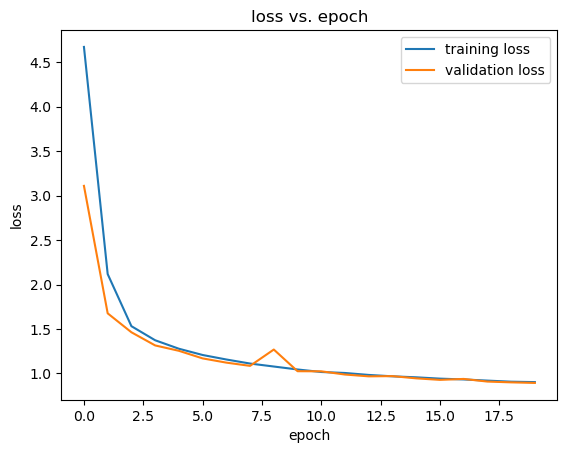

In [11]:
# plot training and validation loss to visualize the training progress.

# We should see that both the training and validation decrease steadily over time.
# Once the validation loss stops decreasing, this is a signal that the model is starting to become overfit

# Load metrics from logged csv file
version = model.logger.version
pt_metrics = pd.read_csv('./logs/linear/version_%i/metrics.csv'%version)
train = pt_metrics[~pt_metrics.train_loss.isna()]
val = pt_metrics[~pt_metrics.val_loss.isna()]
### This code is loading the metrics from the logged csv file generated by the 'logger' object during training, and
### plotting the training loss and validation loss over the course of the training epochs.

# Plot metrics to seaborn lineplot
sns.lineplot(x=train.epoch,y=train.train_loss) #blue
sns.lineplot(x=val.epoch,y=val.val_loss) #orange
plt.title('loss vs. epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss','validation loss'])
# plt.show()
### The blue line = training loss
### the orange line = validation loss
### The purpose of plotting these metrics is to visualize the training progress, and to detect when the
### model starts to become overfitted. When the validation loss stops decreasing, it is a signal that the
### model is starting to become overfitted, and further training will not improve the model's performance on
### unseen data.

import os

# create folder if it does not exist
if not os.path.exists('Graphs'):
    os.makedirs('Graphs')

# create the full path to the file
file_path = os.path.join('Graphs', 'LinearRegression_v5.jpg')
plt.savefig(file_path)

Test performance:
MSE = 0.890
R^2 = 0.830


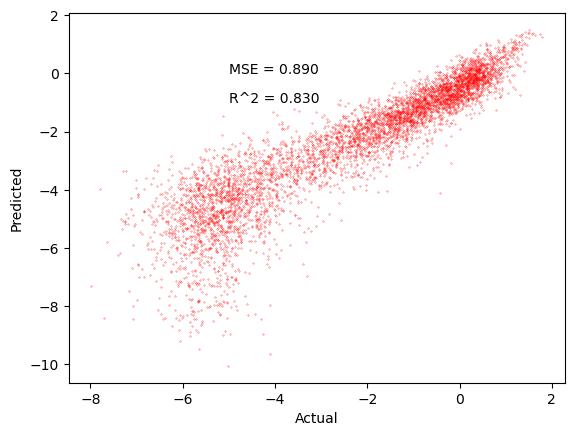

In [12]:
# Plot predicted v true scatterplot for test data

# define the training and test dataframes using the dm splits
train_data_frame = df.iloc[list(dm.train_idx)].copy()
test_data_frame = df.iloc[list(dm.test_idx)].copy()

# Set X as the true scores and Y as the predicted scores
X = test_data_frame['score'].tolist()
Y = []
for i in test_data_frame['AA_sequences']:
    Y.append(model.predict(i))
### Uses the test dataframe defined using the dm splits and the model's predict function to obtain thE
### predicted scores.

# Plot and annotate the test scatterplot
plt.scatter(X, Y, color='red', s = 0.05)
plt.ylabel("Predicted")
plt.xlabel("Actual")

plt.annotate(f"MSE = {metrics.mean_squared_error(X, Y):.3f}", (-5.0, 0.0))
plt.annotate(f"R^2 = {metrics.r2_score(X, Y):.3f}", (-5.0, -1.0))
print('Test performance:')
print(f"MSE = {metrics.mean_squared_error(X, Y):.3f}")
print(f"R^2 = {metrics.r2_score(X, Y):.3f}")
### USES mean squared error and R^2 score from the sklearn library's metrics module to calculate and display
### the MSE and R^2 scores on the plot as annotations

# plt.show()
file_path = os.path.join('Graphs', 'TestPerformance_v5.jpg')
plt.savefig(file_path)

Training performance:
MSE = 0.901
R^2 = 0.827


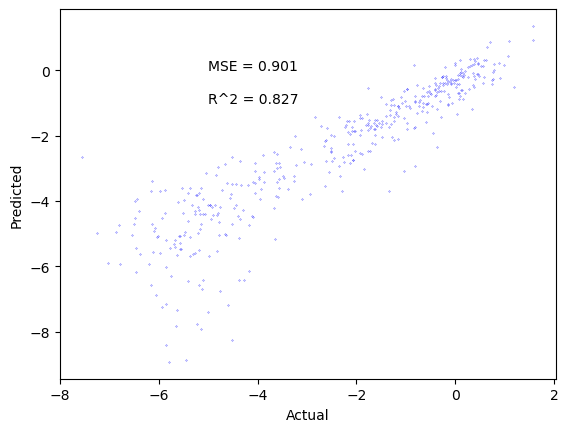

In [13]:
# Plot predicted v true scatterplot for training data

### This code plots a scatter plot of the predicted values versus the actual values for the training data,
### and calculates the mean squared error (MSE) and R-squared values for the predictions.

# Set X as the true scores and Y as the predicted scores
X2 = train_data_frame['score'].tolist()
Y2 = []

for i in train_data_frame['AA_sequences']:
    Y2.append(model.predict(i))

# plot only 1% of the data since there's so much
X2 = X2[:len(X2)//100]
Y2 = Y2[:len(Y2)//100]

# Plot and annotate the training scatterplot
plt.scatter(X2, Y2, color='blue', s = 0.05)
plt.ylabel("Predicted")
plt.xlabel("Actual")

plt.annotate(f"MSE = {metrics.mean_squared_error(X2, Y2):.3f}", (-5.0, 0.0))
plt.annotate(f"R^2 = {metrics.r2_score(X2, Y2):.3f}", (-5.0, -1.))
print('Training performance:')
print(f"MSE = {metrics.mean_squared_error(X2, Y2):.3f}")
print(f"R^2 = {metrics.r2_score(X2, Y2):.3f}")

# plt.show()
file_path = os.path.join('Graphs', 'TrainingPerformance_v5.jpg')
plt.savefig(file_path)

# Note that the test statistics are most important, but if the model performs much better on the training data this
# can be another sign of overfitting
